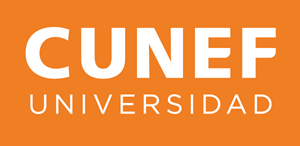
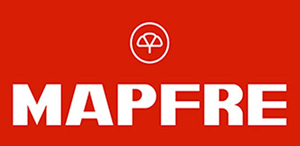

# Master en Data Science - Trabajo Final de Máster

# **5. Implementación de modelos predictivo y causal**
##### <font color='dodgerblue' face='Montserrat'>Autor: Rodrigo Fernandez Campos</font>
### <u>DataSet</u>: IBM - Telco Customer Churn

## Librerías y funciones

In [3]:
# Manipulación de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import importlib
import warnings
import joblib
from IPython.display import Image, IFrame, display

# Modelos
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
import scikitplot as skplt
from sklearn.metrics import balanced_accuracy_score, fbeta_score, make_scorer,\
                            accuracy_score, precision_recall_curve, roc_curve,\
                            auc, recall_score, precision_score, confusion_matrix,\
                            f1_score

# Modelado causal

## PyWhy
from econml.inference import BootstrapInference
from econml.metalearners import XLearner
from econml.dr import LinearDRLearner
from econml.dml import DML
## FKLearn
from fklearn.causal.validation.curves import *
from fklearn.causal.validation.auc import area_under_the_cumulative_effect_curve as auc_cec

# Configs
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

seed=10

In [2]:
sys.path.append('../src/')
import functions_rfc_IBM as fr
importlib.reload(fr)
sys.path.remove('../src/')

## Importando el dataset

In [4]:
df_train_raw = pd.read_parquet('../data/ibm_telco_churn/df_telco_train.parquet')
df_test_raw = pd.read_parquet('../data/ibm_telco_churn/df_telco_test.parquet')
display(df_train_raw.head(), df_train_raw.shape)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Score,CLTV,Churn Reason,Churn Value
2125,0021-IKXGC,1,United States,California,San Marcos,92078,"33.119028, -117.166036",33.119028,-117.166036,Female,Yes,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,72.10,72.10,No,50,4432,None,0
6768,1395-OFUWC,1,United States,California,Los Angeles,90067,"34.057496, -118.413959",34.057496,-118.413959,Male,No,Yes,Yes,43,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Credit card (automatic),29.30,1224.05,No,70,4741,None,0
6796,8080-POTJR,1,United States,California,Rancho Palos Verdes,90275,"33.753146, -118.367459",33.753146,-118.367459,Female,No,No,No,30,Yes,Yes,DSL,Yes,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),79.30,2427.10,No,78,2655,None,0
476,3132-TVFDZ,1,United States,California,Glendale,91202,"34.167926, -118.267539",34.167926,-118.267539,Male,Yes,Yes,No,57,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.85,2572.95,Yes,82,5172,Attitude of support person,1
6706,3898-BSJYF,1,United States,California,Herlong,96113,"40.198234, -120.18089",40.198234,-120.180890,Female,No,No,Yes,10,Yes,Yes,DSL,Yes,No,Yes,Yes,No,Yes,One year,No,Credit card (automatic),73.55,693.30,No,29,4434,None,0


In [5]:
X_train = df_train_raw.drop(columns='Churn Value', axis=1)
y_train = df_train_raw['Churn Value']

X_test = df_test_raw.drop(columns='Churn Value', axis=1)
y_test = df_test_raw['Churn Value']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

## Preprocesamiento

In [6]:
X_train_s = fr.feature_selection(X_train)
X_test_s = fr.feature_selection(X_test)

bools, cats, nums = fr.tipos_vars(X_train_s, show=False)

preprocessor = fr.Preprocessing(X_train_s,
                                cat_transf='mix',
                                scale=True,
                                cat_vars=cats,
                                num_vars=nums,
                                bool_vars=bools,
                                vars_ord=['Contract'],
                                nulls_strategy='median',
                                show_info=True,
                            )

preprocessor.fit(X_train_s, y_train)

X_train_t = preprocessor.transform(X_train_s)
X_test_t = preprocessor.transform(X_test_s)

display(X_train_t.head(), X_train_t.shape, X_test_t.shape)

Prprocessing pipeline defined with the following parameters:
        Mean encoding: ['Payment Method']
        Numerical transformation (scaling=True input strategy=median): ['Tenure Months' 'Monthly Charges' 'CLTV']
        Booleans encoding (ordinal 0-1): ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Paperless Billing']
        Ordinal encoding: ['Contract']
        One-Hot encoding: []


,Tenure Months,Monthly Charges,CLTV,Contract,Payment Method,Senior Citizen,Partner,Dependents,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Paperless Billing
2125,-1.299099,-0.217742,0.018351,0.0,0.471083,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
6768,0.411249,-2.175807,0.280323,0.0,0.190022,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6796,-0.118144,0.111652,-1.488203,1.0,0.190022,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
476,0.981365,-1.464407,0.645728,0.0,0.471083,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6706,-0.932596,-0.151406,0.020046,1.0,0.190022,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [7]:
df_train = pd.concat([X_train_t, y_train], axis=1)
df_test = pd.concat([X_test_t, y_test], axis=1)

## Modelado Predictivo: LightGBM y Logistic Regression

In [42]:
cv = joblib.load('../models/CV_rs_lgbm_IBM.joblib')

In [43]:
cv.best_params_

{'num_leaves': 11,
 'n_estimators ': 200,
 'min_data_in_leaf': 400,
 'max_depth': 3,
 'learning_rate': 0.05,
 'lambda_l2': 0.5,
 'lambda_l1': 0}

In [9]:
lgbm = LGBMClassifier(verbose=-1
                      ,max_depth=3
                      ,min_data_in_leaf=400
                      ,n_estimators=200
                      ,num_leaves=11
                      ,learning_rate=0.05
                      ,random_state=seed
                      ,lambda_l2=0.5
                     )

lgbm.fit(X_train_t, y_train)

y_pred_lgbm = lgbm.predict(X_test_t)

fr.metrics_summ(y_test, y_pred_lgbm)


Accuracy: 0.77899
Balanced Accuracy: 0.73455
F2 score: 0.62247
F1 score: 0.63798
Precision: 0.66563
Recall: 0.61254

Confusion Matrix:
[[645 108]
 [136 215]]


,Model,Accuracy,Balanced Accuracy,F2 Score,F1 Score,Precision,Recall
0,Model,0.778986,0.734555,0.622467,0.637982,0.665635,0.612536


In [45]:
lr = LogisticRegression(random_state=seed)

lr.fit(X_train_t, y_train)

y_pred_lr = lr.predict(X_test_t)

fr.metrics_summ(y_test, y_pred_lr)


Accuracy: 0.78080
Balanced Accuracy: 0.73512
F2 score: 0.62101
F1 score: 0.63881
Precision: 0.67085
Recall: 0.60969

Confusion Matrix:
[[648 105]
 [137 214]]


,Model,Accuracy,Balanced Accuracy,F2 Score,F1 Score,Precision,Recall
0,Model,0.780797,0.735122,0.62101,0.638806,0.670846,0.609687


In [29]:
y_pred_proba_lgbm = lgbm.predict_proba(X_test_t)
probas_lgbm = pd.concat([pd.Series(y_pred_proba_lgbm[:,1]),pd.Series(y_pred_lgbm)],axis=1).rename(columns={0:'Probability', 1:'Default'})
probas_lgbm[probas_lgbm.Default == 1].Probability.describe()

count    323.000000
mean       0.666330
std        0.098385
min        0.500579
25%        0.581473
50%        0.660522
75%        0.731450
max        0.892173
Name: Probability, dtype: float64

In [34]:
probas_lgbm.mean()

Probability    0.318159
Default        0.292572
dtype: float64

In [28]:
probas_lgbm

,Probability,Default
0,0.877256,1
1,0.554158,1
2,0.544986,1
3,0.033782,0
4,0.023044,0
...,...,...
1099,0.069885,0
1100,0.681303,1
1101,0.018970,0
1102,0.735631,1


In [30]:
y_pred_proba_lr = lr.predict_proba(X_test_t)
probas_lr = pd.concat([pd.Series(y_pred_proba_lr[:,1]),pd.Series(y_pred_lr)],axis=1).rename(columns={0:'Probability', 1:'Default'})
probas_lr[probas_lr.Default == 1].Probability.describe()

count    319.000000
mean       0.660932
std        0.087186
min        0.501344
25%        0.593807
50%        0.658975
75%        0.728392
max        0.861592
Name: Probability, dtype: float64

In [33]:
probas_lr.mean()

Probability    0.316265
Default        0.288949
dtype: float64

In [119]:
df_aux_lgbm = pd.concat([pd.Series(probas_lgbm.Probability)
                        ,y_test.reset_index(drop=False)
                        ], axis=1).rename(columns={'Probability':'y_pred_proba','Churn Value':'y_true'})

df_aux_lr = pd.concat([pd.Series(probas_lr.Probability)
                      ,y_test.reset_index(drop=False)
                      ], axis=1).rename(columns={'Probability':'y_pred_proba','Churn Value':'y_true'})

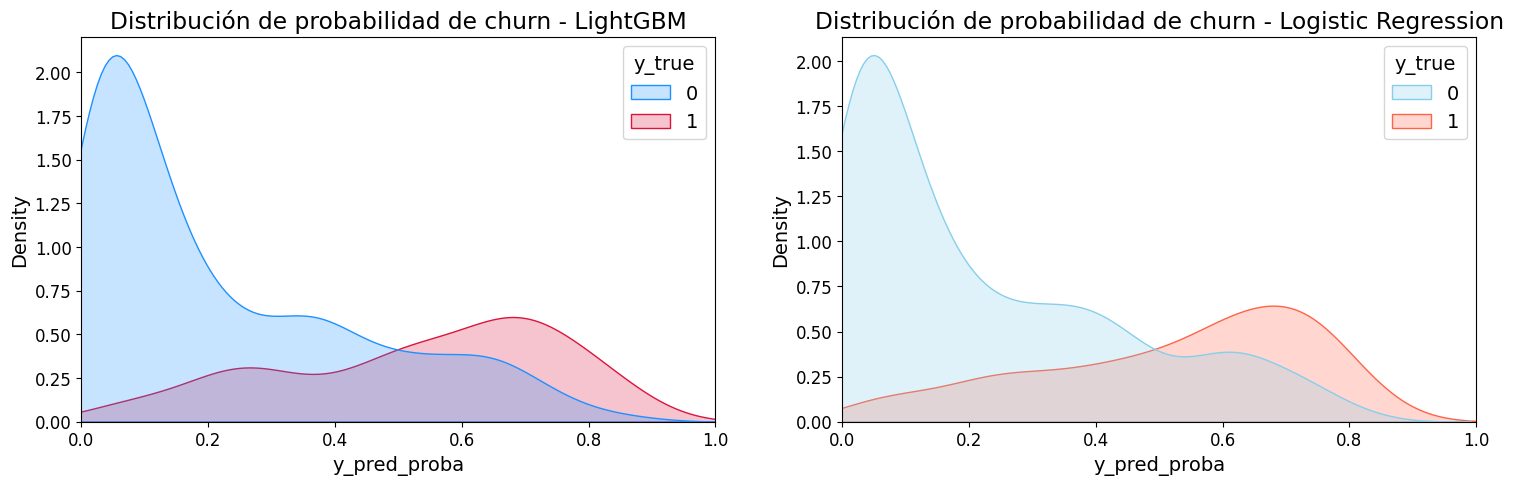

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

sns.kdeplot(data=df_aux_lgbm, x='y_pred_proba', hue='y_true', ax=ax1, fill=True, palette=['dodgerblue','crimson'])
sns.kdeplot(data=df_aux_lr, x='y_pred_proba', hue='y_true', ax=ax2, fill=True, palette=['skyblue','tomato'])

ax1.set_title('Distribución de probabilidad de churn - LightGBM')
ax1.set_xlim(0,1)

ax2.set_title('Distribución de probabilidad de churn - Logistic Regression')
ax2.set_xlim(0,1)

plt.show()

Best Threshold = 0.419935, G-Mean = 0.760

*************************************************************

El coeficiente de GINI es: 0.68

El área por debajo de la curva ROC es: 0.8387

*************************************************************


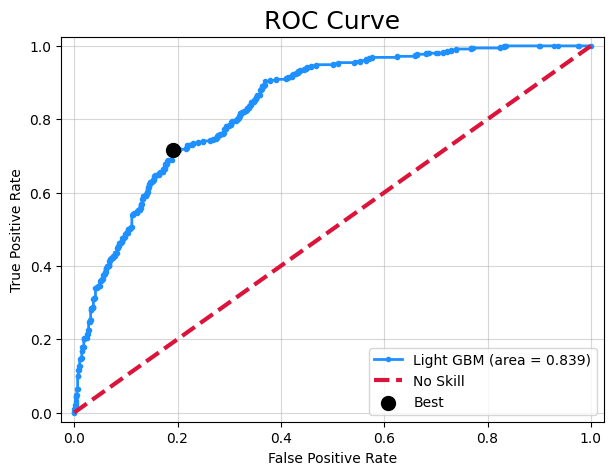

In [60]:
fr.roc_curve_plot(y_test, probas_lgbm.Probability, model_name='Light GBM', figsize=(7,5))
plt.show()

Best Threshold = 0.384932, G-Mean = 0.753

*************************************************************

El coeficiente de GINI es: 0.66

El área por debajo de la curva ROC es: 0.8307

*************************************************************


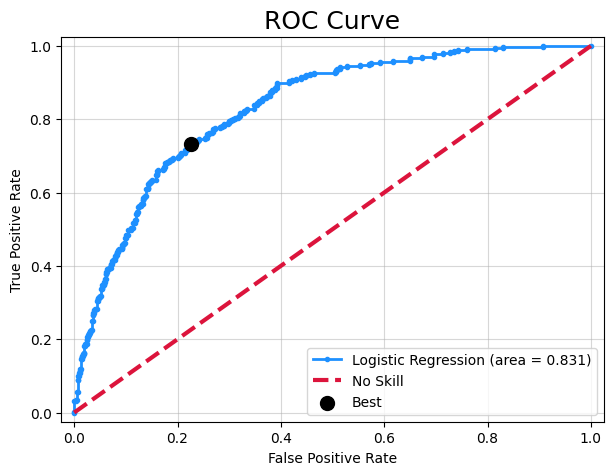

In [61]:
fr.roc_curve_plot(y_test, probas_lr.Probability, model_name='Logistic Regression', figsize=(7,5))
plt.show()

Best Threshold = 0.15550, F2 Score = 0.798, AUC = 0.6876


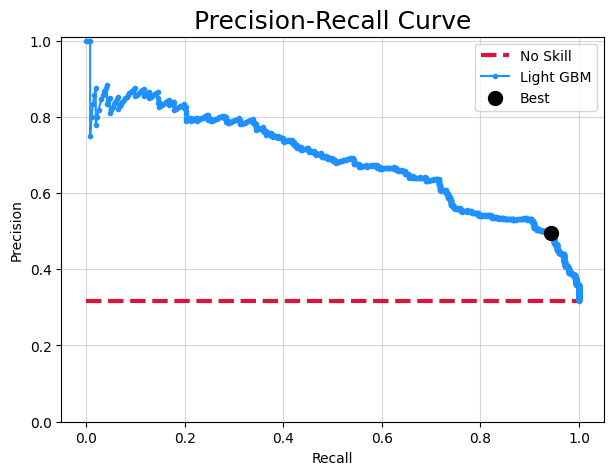

In [62]:
fr.pr_curve_plot(y_test, probas_lgbm.Probability, f_score_beta=2, model_name='Light GBM', figsize=(7,5))

Best Threshold = 0.16404, F2 Score = 0.782, AUC = 0.6773


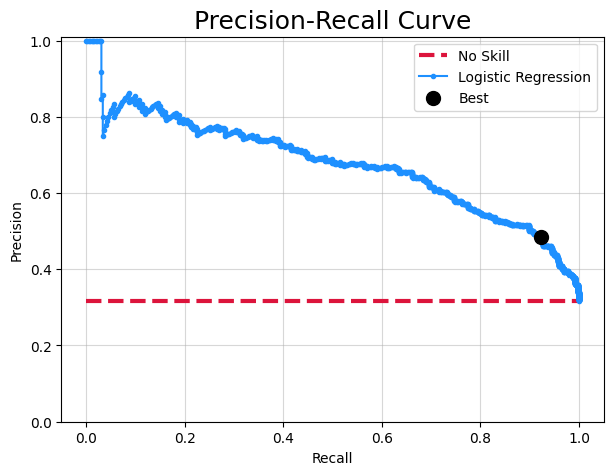

In [63]:
fr.pr_curve_plot(y_test, probas_lr.Probability, f_score_beta=2, model_name='Logistic Regression', figsize=(7,5))

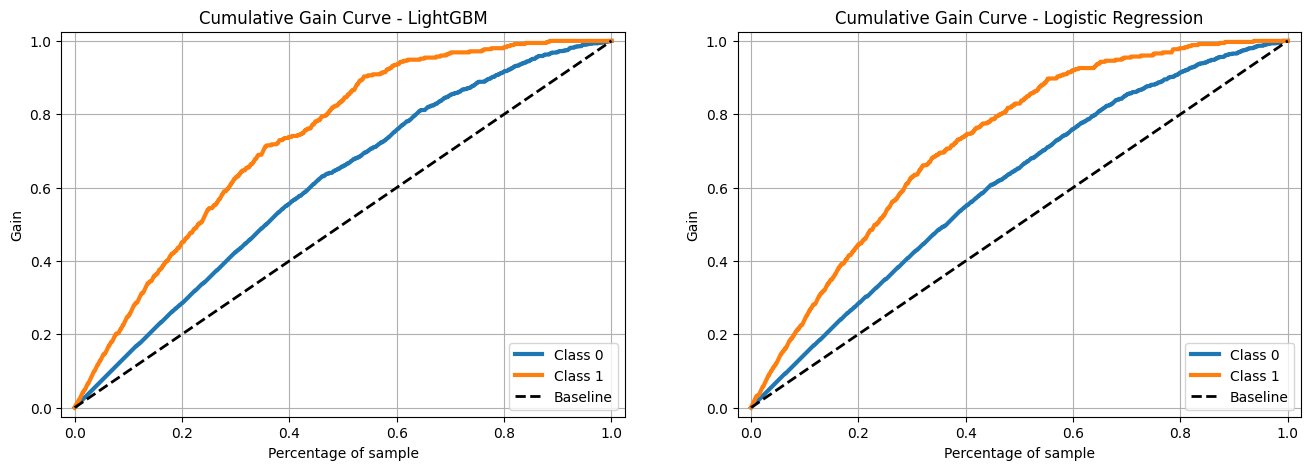

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba_lgbm, ax=ax1, title='Cumulative Gain Curve - LightGBM')
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba_lr, ax=ax2, title='Cumulative Gain Curve - Logistic Regression')
ax1.set_xlim([-0.025, 1.025])
ax1.set_ylim([-0.025, 1.025])
ax2.set_xlim([-0.025, 1.025])
ax2.set_ylim([-0.025, 1.025])
plt.show()

In [76]:
%%time
prob_predictions_lgbm = probas_lgbm.Probability
recall_precision_lgbm = []

for threshold in np.arange(0.01, 0.99, 0.01):
    given_threshold = [1 if value>threshold else 0 for value in prob_predictions_lgbm]
    recall_precision_lgbm.append([threshold, recall_score(y_test, given_threshold)
                            ,precision_score(y_test, given_threshold)
                            ,fbeta_score(y_test, given_threshold, beta=2)
                            ,f1_score(y_test, given_threshold)])

prob_predictions_lr = probas_lr.Probability
recall_precision_lr = []

for threshold in np.arange(0.01, 0.99, 0.01):
    given_threshold = [1 if value>threshold else 0 for value in prob_predictions_lr]
    recall_precision_lr.append([threshold, recall_score(y_test, given_threshold)
                            ,precision_score(y_test, given_threshold)
                            ,fbeta_score(y_test, given_threshold, beta=2)
                            ,f1_score(y_test, given_threshold)])

CPU times: total: 641 ms
Wall time: 1.85 s


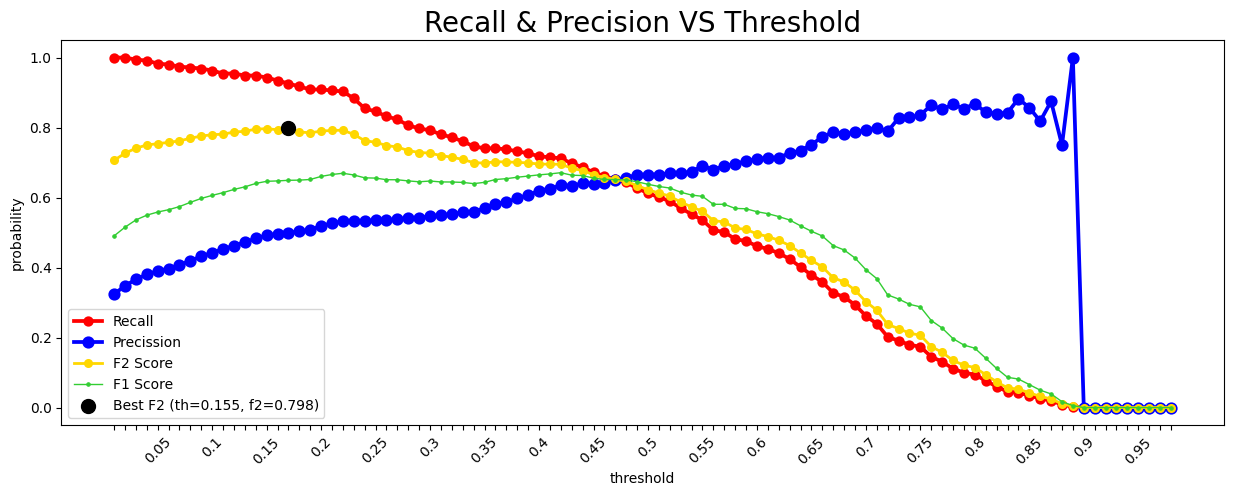

In [77]:
fr.plot_recall_precission(recall_precision_lgbm, y_test, probas_lgbm.Probability)

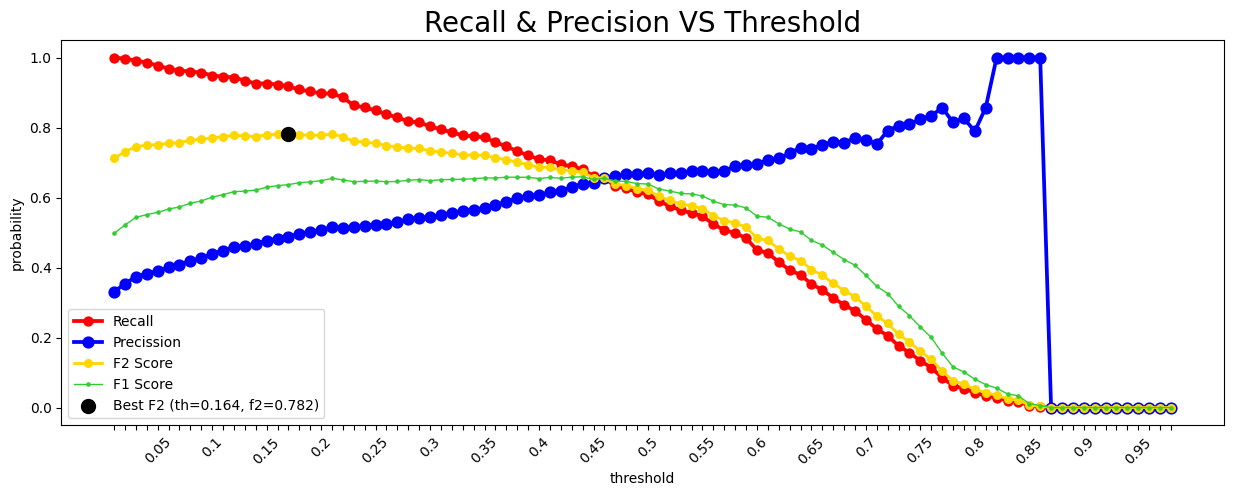

In [78]:
fr.plot_recall_precission(recall_precision_lr, y_test, probas_lr.Probability)

In [80]:
y_pred_lgbm_roc = np.where(probas_lgbm.Probability>0.419935,1,0)
y_pred_lgbm_f2 = np.where(probas_lgbm.Probability>0.15550,1,0) 

y_pred_lr_roc = np.where(probas_lr.Probability>0.384932,1,0)
y_pred_lr_f2 = np.where(probas_lr.Probability>0.16404,1,0)

In [85]:
print("\033[1mLightGBM - Máximizando el F2 --> Threshold 0.155:\033[0m")
fr.metrics_summ(y_test, y_pred_lgbm_f2)
print('__________________________________________\n')

print("\033[1mLightGBM - Mejor proporción promedio TP y FP, óptimo curva ROC --> Threshold 0.42\033[0m")
fr.metrics_summ(y_test, y_pred_lgbm_roc)
print('\n')

print('\033[1m-------------------------------------------------------------------------\033[0m \n')

print("\033[1mLogistic Regression - Máximizando el F2 --> Threshold 0.16:\033[0m")
fr.metrics_summ(y_test, y_pred_lr_f2)
print('__________________________________________\n')

print("\033[1mLogistic Regression - Mejor proporción promedio TP y FP, óptimo curva ROC --> Threshold 0.38\033[0m")
fr.metrics_summ(y_test, y_pred_lr_roc)

LightGBM - Máximizando el F2 --> Threshold 0.155:

Accuracy: 0.67391
Balanced Accuracy: 0.74499
F2 score: 0.79595
F1 score: 0.64706
Precision: 0.49327
Recall: 0.94017

Confusion Matrix:
[[414 339]
 [ 21 330]]
__________________________________________

LightGBM - Mejor proporción promedio TP y FP, óptimo curva ROC --> Threshold 0.42

Accuracy: 0.77808
Balanced Accuracy: 0.76051
F2 score: 0.69522
F1 score: 0.67114
Precision: 0.63452
Recall: 0.71225

Confusion Matrix:
[[609 144]
 [101 250]]


------------------------------------------------------------------------- 

Logistic Regression - Máximizando el F2 --> Threshold 0.16:

Accuracy: 0.66395
Balanced Accuracy: 0.73236
F2 score: 0.78019
F1 score: 0.63520
Precision: 0.48498
Recall: 0.92023

Confusion Matrix:
[[410 343]
 [ 28 323]]
__________________________________________

Logistic Regression - Mejor proporción promedio TP y FP, óptimo curva ROC --> Threshold 0.38

Accuracy: 0.76087
Balanced Accuracy: 0.75322
F2 score: 0.70180
F1 score

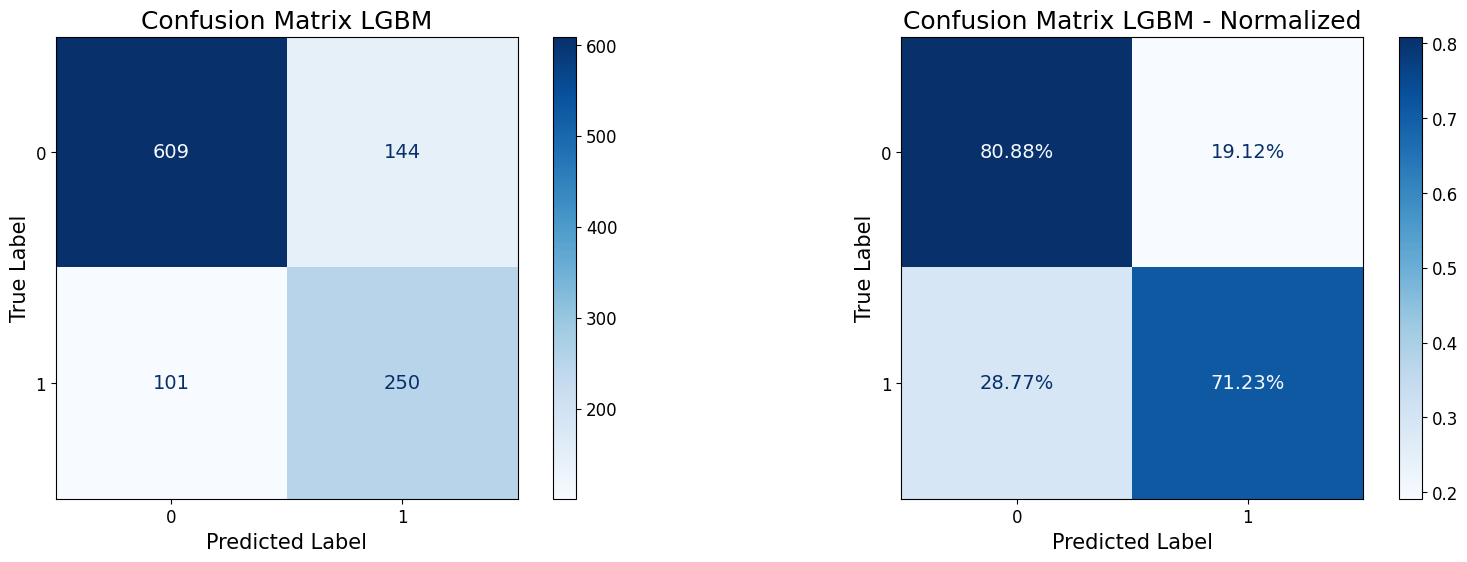

In [87]:
fr.plot_cmatrix(y_test, y_pred_lgbm_roc, title='Confusion Matrix LGBM')

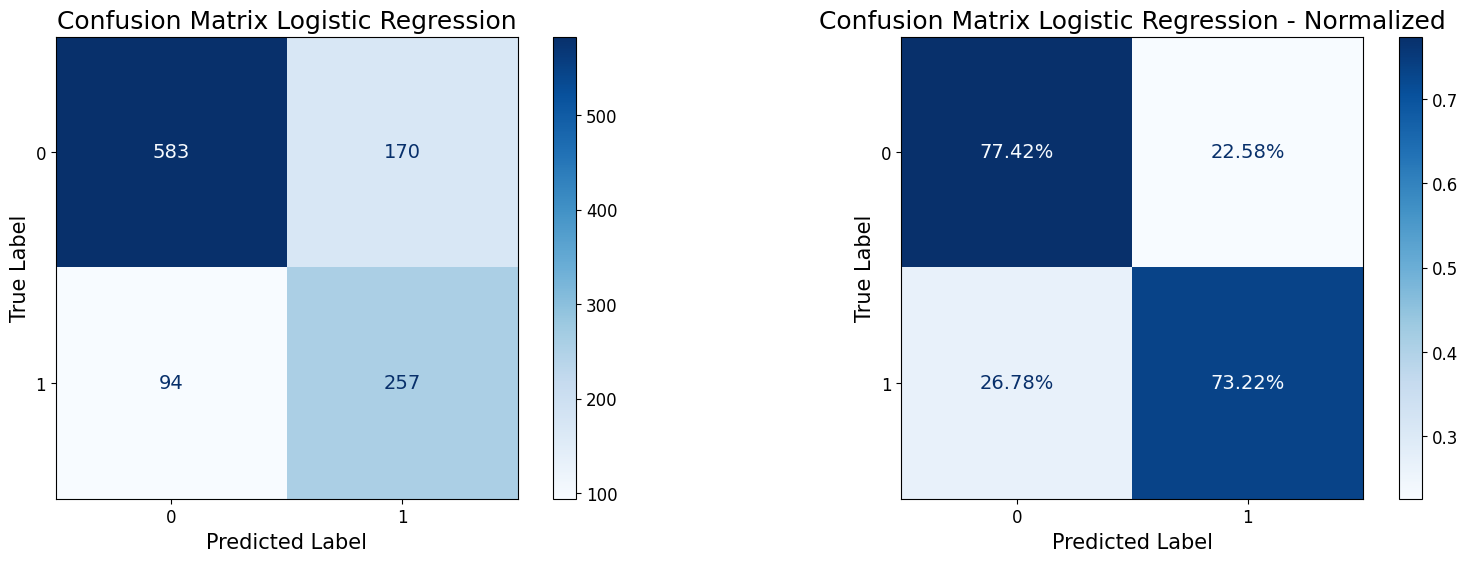

In [88]:
fr.plot_cmatrix(y_test, y_pred_lr_roc, title='Confusion Matrix Logistic Regression')

In [125]:
lgbm_threshold = 0.419935
lr_threshold = 0.384932

# Modelado Causal

In [90]:
xlearner = XLearner(models=LGBMRegressor(verbose=-1, max_depth=3, lambda_l1=5, lambda_l2=5)
                    ,propensity_model=LGBMClassifier(verbose=-1, max_depth=3, lambda_l1=5, lambda_l2=5))

In [91]:
xlearner.fit(Y=y_train.values, T=X_train_t['Tech Support'].values, X=X_train_t.drop('Tech Support', axis=1).values, inference="bootstrap")

In [92]:
cate_test = xlearner.effect(X_test_t.drop('Tech Support', axis=1).values)

In [93]:
pd.Series(cate_test).describe()

count    1104.000000
mean       -0.060624
std         0.074660
min        -0.281783
25%        -0.119530
50%        -0.061386
75%        -0.002692
max         0.157892
dtype: float64

In [96]:
pd.Series(xlearner.effect(X_train_t.drop('Tech Support', axis=1).values)).describe()

count    4413.000000
mean       -0.060137
std         0.073300
min        -0.275773
25%        -0.116577
50%        -0.058595
75%        -0.004685
max         0.153527
dtype: float64

In [97]:
xlearner.ate(X_test_t.drop('Tech Support', axis=1).values)

In [98]:
xlearner.ate_interval(X_test_t.drop('Tech Support', axis=1).values)

In [99]:
xlearner.ate(X_train_t.drop('Tech Support', axis=1).values)

In [100]:
xlearner.ate_interval(X_train_t.drop('Tech Support', axis=1).values)

In [102]:
(xlearner
 .effect_interval(X_test_t.drop('Tech Support', axis=1).values, alpha=0.05)[0]
 .mean()
 
 ,xlearner
 .effect_interval(X_test_t.drop('Tech Support', axis=1).values, alpha=0.05)[1]
 .mean()
)

In [122]:
df_cates = df_aux_lgbm.copy()
df_cates['CATE'] = pd.Series(cate_test).copy()
df_cates

,y_pred_proba,index,y_true,CATE
0,0.877256,515,1,-0.160545
1,0.554158,597,1,-0.102517
2,0.544986,3967,0,-0.134479
3,0.033782,1985,0,0.026660
4,0.023044,5737,0,0.041515
...,...,...,...,...
1099,0.069885,969,1,-0.021753
1100,0.681303,642,1,-0.157216
1101,0.018970,5262,0,0.030759
1102,0.735631,822,1,-0.138468


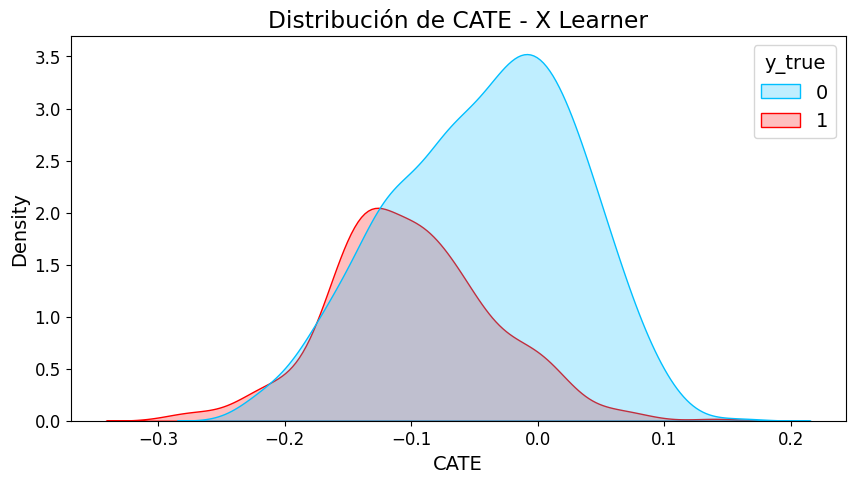

In [194]:
fig, ax = plt.subplots(figsize=(10,5))

sns.kdeplot(data=df_cates, x='CATE', hue='y_true', ax=ax, fill=True, palette=['deepskyblue','red'])

ax.set_title('Distribución de CATE - X Learner')
plt.show()

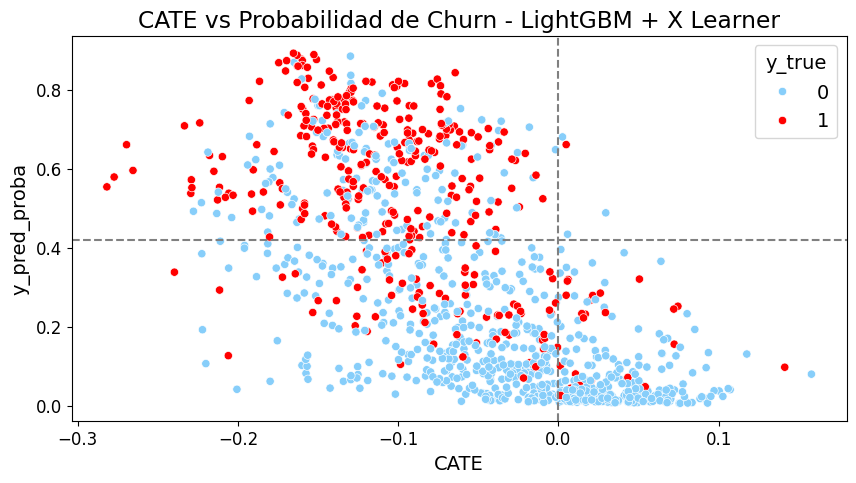

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(data=df_cates
                ,x='CATE'
                ,y='y_pred_proba'
                ,hue='y_true'
                ,palette={0:'lightskyblue', 1:'red'}
                ,ax=ax)

# línea negra a rayas intermitentes en y=0,4
ax.axhline(y=lgbm_threshold, color='grey', linestyle='--')
ax.axvline(x=0, color='grey', linestyle='--')

ax.set_title('CATE vs Probabilidad de Churn - LightGBM + X Learner')

plt.show()

In [130]:
aplicar_treatment = df_cates[(df_cates.y_pred_proba > lgbm_threshold) & (df_cates.CATE < 0)]
display(aplicar_treatment.head(), aplicar_treatment.shape)

,y_pred_proba,index,y_true,CATE
0,0.877256,515,1,-0.160545
1,0.554158,597,1,-0.102517
2,0.544986,3967,0,-0.134479
6,0.522660,1544,1,-0.131325
10,0.488396,2021,0,-0.053810


In [133]:
aplicar_treatment.y_true.value_counts(normalize=True)

y_true
1    0.638462
0    0.361538
Name: proportion, dtype: float64

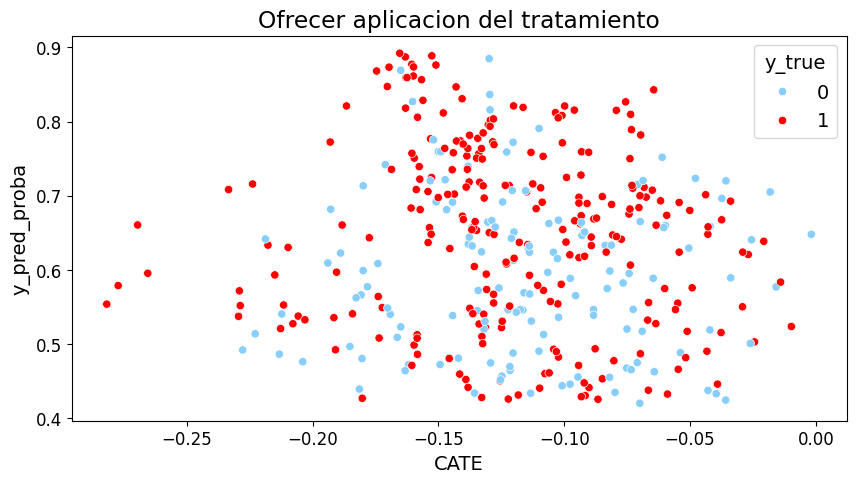

In [150]:
fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(data=aplicar_treatment
                ,x='CATE'
                ,y='y_pred_proba'
                ,hue='y_true'
                ,palette={0:'lightskyblue', 1:'red'})

ax.set_title('Ofrecer aplicacion del tratamiento (Soporte Técnico gratuito por ejemplo)')

plt.show()

In [191]:
df_test_to_treat = df_test_raw.reset_index(drop=False).copy()
df_test_to_treat = df_test_to_treat[df_test_to_treat['index'].isin(aplicar_treatment['index'].values)]

In [192]:
display(df_test_to_treat.head(), df_test_to_treat.shape)

,index,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Score,CLTV,Churn Reason,Churn Value
0,515,9497-QCMMS,1,United States,California,Escondido,92026,"33.21846, -117.116916",33.218460,-117.116916,Male,Yes,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,93.55,93.55,Yes,81,5536,Competitor made better offer,1
1,597,0320-JDNQG,1,United States,California,Oxnard,93035,"34.18454, -119.224666",34.184540,-119.224666,Male,No,Yes,No,23,Yes,No,Fiber optic,Yes,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,99.85,2331.30,Yes,83,3425,Don't know,1
2,3967,9743-DQKQW,1,United States,California,Escalon,95320,"37.818543, -121.006907",37.818543,-121.006907,Male,No,No,No,3,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,25.10,79.80,No,58,2013,None,0
6,1544,3398-ZOUAA,1,United States,California,Redwood City,94063,"37.499411, -122.196318",37.499411,-122.196318,Male,Yes,Yes,No,21,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.10,1474.75,Yes,67,3853,Attitude of support person,1
10,2021,8544-GOQSH,1,United States,California,Pacoima,91331,"34.255442, -118.421314",34.255442,-118.421314,Female,No,No,No,14,Yes,No,Fiber optic,No,Yes,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),80.05,1112.30,No,53,4400,None,0


# Exportando modelos y dataframes procesados

In [196]:
joblib.dump(lgbm, '../models/lgbm_model.joblib')
joblib.dump(lr, '../models/logistic_regression_model.joblib')
joblib.dump(xlearner, '../models/Xlearner_model.joblib')

['../models/Xlearner_model.joblib']

In [198]:
df_train.to_parquet('../data/ibm_telco_churn/processed/df_train_processed.parquet')
df_test.to_parquet('../data/ibm_telco_churn/processed/df_test_processed.parquet')
df_cates.to_parquet('../data/ibm_telco_churn/processed/df_cates.parquet')
aplicar_treatment.to_parquet('../data/ibm_telco_churn/processed/df_aplicar_treatment.parquet')